In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.svm import l1_min_c
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Load Data Sets

In [2]:
filename = os.path.join(os.getcwd(), "data", "stress_data.csv")
df = pd.read_csv(filename, header=0)

### Problem Statement

We will be predicting burnout based on healthcare worker data. A company that wants to improve quality of life for workers while still retaining efficiency may be interested in predicting how often their workers burn out, as burnout is directly related to less productivity. We can also use what the model predicts to not only signal when a worker is not as efficient, but also reveal what is necessary to help workers burn out less in the future. 

### Inspect Data

Displays first 5 rows of dataframe

In [3]:
df.head()

,EMPLOYEE ID,Hours Worked,Break Count,Break Time,Meals Eaten,Sleep,Stress,Fatigue,Efficiency
0,1,76,4,15,2,6,8,8,3
1,1,81,3,10,2,5,9,9,2
2,1,71,5,20,2,7,7,7,4
3,1,71,5,20,2,7,7,7,4
4,1,76,4,15,2,6,8,8,3


In [4]:
print("number of rows:", df.shape[0])
print("number of cols:", df.shape[1])

number of rows: 1299
number of cols: 9


Displays count, mean, std, and min/max of each column

In [5]:
df.describe(include='all')

,EMPLOYEE ID,Hours Worked,Break Count,Break Time,Meals Eaten,Sleep,Stress,Fatigue,Efficiency
count,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000,1299.000000
mean,6.767513,55.327175,2.779061,18.475751,2.327175,6.080831,5.887606,6.234026,5.698999
std,4.137635,14.775045,1.560192,8.447791,0.660316,1.660405,2.843584,2.652274,2.536226
min,1.000000,25.000000,1.000000,5.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,3.000000,45.000000,2.000000,10.000000,2.000000,5.000000,3.000000,4.000000,4.000000
50%,6.000000,55.000000,3.000000,20.000000,2.000000,6.000000,6.000000,7.000000,6.000000
75%,10.000000,65.000000,4.000000,25.000000,3.000000,7.000000,8.000000,9.000000,8.000000
max,14.000000,90.000000,8.000000,35.000000,3.000000,9.000000,10.000000,10.000000,10.000000


Each column's datatype

In [6]:
df.dtypes

EMPLOYEE ID      int64
Hours Worked     int64
Break Count      int64
Break Time       int64
Meals Eaten      int64
Sleep            int64
Stress           int64
Fatigue          int64
Efficiency       int64
dtype: object

Here we used a formula to calculate burnout. Our values for stress and fatigue are negative and weighted by 0.75 while our values for efficiency are positive and weighted by 1.

In [7]:
df['Burnout'] = -0.75 * df['Stress'] + -0.75 * df['Fatigue'] + df['Efficiency']
df.drop(columns=['Stress', 'Fatigue', 'Efficiency'], inplace=True)
label = 'Burnout'

In [8]:
df.head()

,EMPLOYEE ID,Hours Worked,Break Count,Break Time,Meals Eaten,Sleep,Burnout
0,1,76,4,15,2,6,-9.0
1,1,81,3,10,2,5,-11.5
2,1,71,5,20,2,7,-6.5
3,1,71,5,20,2,7,-6.5
4,1,76,4,15,2,6,-9.0


We create labeled examples and then split the examples into training and test sets.

In [9]:
# Create labeled examples
y = df[label]
X = df.drop(columns=['EMPLOYEE ID', label], axis=1)

# Split examples into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

### Checking for Null Values

Due to the constraints of our google form, people who chose to answer had to answer all parts which resulted in 0 null values for each category. If people choose not to answer certain questions, we can check for null values using another function but in this case it was unnecessary.

In [10]:
df.isnull().sum()

EMPLOYEE ID      0
Hours Worked     0
Break Count      0
Break Time       0
Meals Eaten      0
Sleep            0
Burnout          0
dtype: int64

### Training Model on Aggregate Data

In [11]:
# Train model
lr_model = GradientBoostingRegressor()
lr_model.fit(X_train, y_train)

# Evaluate model
lr_pred = lr_model.predict(X_test)
lr_r2_score = r2_score(lr_pred, y_test)
print('[LR] R2 Score: {0}'.format(lr_r2_score))
lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
print('[LR] RMSE: {0}'.format(lr_rmse))

[LR] R2 Score: 0.9851770177364944
[LR] RMSE: 0.7698930152619692


R2 Score closer to 1 is good, goes from 0 to 1
RMSE: on average, predictions are off by 1.07 -- not bad considering scale of 1-10

### Create Employee's Individual Models

We want to provide suggestions tailored to each individual employee based on their historical data rather than aggregating all employee's data. We recognize that each person is unique and experiences burnout under different circumstances. Thus, we trained unique models for each of the employees based on their employee IDs.

In [12]:
def createModel(employee, minExamples=300):
    # Create labeled examples
    df_emp = df[df['EMPLOYEE ID'] == employee]
    numExamples = df_emp.shape[0]
    if minExamples > df_emp.shape[0]:
        diff = minExamples - df_emp.shape[0]
        df_notEmp = df[df['EMPLOYEE ID'] != employee]
        df_notEmp = df_notEmp.sample(min(diff, df_notEmp.shape[0]))
        df_emp = pd.concat([df_emp, df_notEmp])
    y = df_emp[label]
    X = df_emp.drop(columns=['EMPLOYEE ID', label], axis=1)

    # Split examples into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)
    # Train model
    lr_model = GradientBoostingRegressor()
    lr_model.fit(X_train, y_train)

    # Evaluate model
    print('\nModel for Employee {0}: {1} data entries'.format(employee, numExamples))
    lr_pred = lr_model.predict(X_test)
    lr_r2_score = r2_score(lr_pred, y_test)
    print('[LR] R2 Score: {0}'.format(lr_r2_score))
    lr_rmse = mean_squared_error(y_test, lr_pred, squared=False)
    print('[LR] RMSE: {0}'.format(lr_rmse))
    
    return lr_model

In [13]:
employees = df['EMPLOYEE ID'].unique()
employees

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [14]:
emp_models = {emp:createModel(emp) for emp in employees}


Model for Employee 1: 100 data entries
[LR] R2 Score: 0.9689638712227662
[LR] RMSE: 1.0891519084280306

Model for Employee 2: 100 data entries
[LR] R2 Score: 0.8979683388800588
[LR] RMSE: 1.6949063087111056

Model for Employee 3: 150 data entries
[LR] R2 Score: 0.9616115330599839
[LR] RMSE: 1.0774196682563026

Model for Employee 4: 200 data entries
[LR] R2 Score: 0.7637063913730429
[LR] RMSE: 2.7443958065517835

Model for Employee 5: 50 data entries
[LR] R2 Score: 0.9767741825829052
[LR] RMSE: 0.9428885210302658

Model for Employee 6: 100 data entries
[LR] R2 Score: 0.9346266711766171
[LR] RMSE: 1.5905344424039514

Model for Employee 7: 99 data entries
[LR] R2 Score: 0.9362184022778915
[LR] RMSE: 1.5227218735225827

Model for Employee 8: 51 data entries
[LR] R2 Score: 0.9686507430213107
[LR] RMSE: 1.1897135684484024

Model for Employee 9: 50 data entries
[LR] R2 Score: 0.980880638688502
[LR] RMSE: 0.7823413346739603

Model for Employee 10: 99 data entries
[LR] R2 Score: 0.948043700397

In [15]:
df.columns

Index(['EMPLOYEE ID', 'Hours Worked ', 'Break Count', 'Break Time',
       'Meals Eaten', 'Sleep', 'Burnout'],
      dtype='object')

In [16]:
features = df.columns[1:-1]
features

Index(['Hours Worked ', 'Break Count', 'Break Time', 'Meals Eaten', 'Sleep'], dtype='object')

We also set a possible range of values that our model is restricted by realism. This prevents the model from returning answers such as "work 0 hours for less burnout" or "Take 3 hour long breaks for less burnout"

In [17]:
possible_values = {'Hours Worked ': list(range(20,80)),
                  'Break Count': list(range(0, 10)),
                  'Break Time': list(range(5,60)),
                  'Meals Eaten': list(range(1,5)),
                  'Sleep': list(range(5,10))}

Here is the function that is used to get the optimal params for each unique employee

In [18]:
def getOptimalParams(employee):
    pv = possible_values
    emp_model = createModel(employee)
    combos = []
    for h in pv['Hours Worked ']:
        for bc in pv['Break Count']:
            for bt in pv['Break Time']:
                for m in pv['Meals Eaten']:
                    for s in pv['Sleep']:
                        combos.append([h, bc, bt, m, s])
    X_test = pd.DataFrame(np.array(combos), columns=features)
    emp_pred = emp_model.predict(X_test)
    return combos[np.argmax(emp_pred)], np.max(emp_pred)

An example of the optimal parameters of employee 1:

In [19]:
opt_params = getOptimalParams(1)
print()
print("Hours Worked:", opt_params[0][0])
print("Break Count:", opt_params[0][1])
print("Break Time:", opt_params[0][2])
print("Meals Eaten:", opt_params[0][3])
print("Sleep:", opt_params[0][4])
print("Optimal Burnout Rate:", opt_params[1])


Model for Employee 1: 100 data entries
[LR] R2 Score: 0.9559352717096689
[LR] RMSE: 1.3680281235404699

Hours Worked: 20
Break Count: 0
Break Time: 26
Meals Eaten: 3
Sleep: 8
Optimal Burnout Rate: 11.846444785604039


We now get all the params for all employees

In [20]:
finData = [getOptimalParams(emp) for emp in employees]

finData


Model for Employee 1: 100 data entries
[LR] R2 Score: 0.9557265761053555
[LR] RMSE: 1.3318225316381371

Model for Employee 2: 100 data entries
[LR] R2 Score: 0.9846193030792276
[LR] RMSE: 0.6913664351931893

Model for Employee 3: 150 data entries
[LR] R2 Score: 0.8478223636366088
[LR] RMSE: 1.8975253073080702

Model for Employee 4: 200 data entries
[LR] R2 Score: 0.7881780027682941
[LR] RMSE: 2.5260001015642297

Model for Employee 5: 50 data entries
[LR] R2 Score: 0.9619082227670939
[LR] RMSE: 1.3429232070256212

Model for Employee 6: 100 data entries
[LR] R2 Score: 0.9689567175425451
[LR] RMSE: 1.0054762903357657

Model for Employee 7: 99 data entries
[LR] R2 Score: 0.9043622646651316
[LR] RMSE: 1.5208440583033216

Model for Employee 8: 51 data entries
[LR] R2 Score: 0.9672843165473466
[LR] RMSE: 1.146490017734613

Model for Employee 9: 50 data entries
[LR] R2 Score: 0.9671220436477412
[LR] RMSE: 1.06552886228404

Model for Employee 10: 99 data entries
[LR] R2 Score: 0.97383172226801

[([20, 0, 23, 3, 9], 11.176158317934997),
 ([20, 2, 18, 3, 7], 8.618765736233716),
 ([59, 0, 23, 1, 9], 8.562606913985196),
 ([20, 3, 13, 3, 7], 8.242013482990263),
 ([20, 0, 13, 1, 9], 11.109755054575864),
 ([20, 0, 5, 3, 5], 11.16228605459981),
 ([56, 0, 8, 1, 9], 10.618398212254684),
 ([28, 0, 8, 3, 7], 10.978187192450994),
 ([42, 0, 23, 2, 9], 10.69853620232555),
 ([28, 0, 5, 3, 7], 11.206327263034588),
 ([20, 0, 5, 3, 5], 10.34613319941862),
 ([20, 0, 23, 3, 9], 12.120041261384008),
 ([54, 0, 23, 2, 9], 11.274446401446836),
 ([20, 4, 23, 2, 9], 10.922298563504855)]

In [22]:
def getFeatureImportances(top_num):
    # Create labeled examples
    y = df[label]
    X = df.drop(columns=['EMPLOYEE ID', label], axis=1)

    # Split examples into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
    
    # Perform model selection
    param_grid = {'max_depth':list(range(5,9)), 'min_samples_leaf':list(range(25, 51))}
    model = DecisionTreeRegressor()
    grid = GridSearchCV(model, param_grid, cv=3, scoring=make_scorer(r2_score))
    grid_search = grid.fit(X_train, y_train)
    best_params = {'max_depth':grid_search.best_estimator_.max_depth, 'min_samples_leaf':grid_search.best_estimator_.min_samples_leaf}
    print('The best params for the model is :', best_params)
    r2 = grid_search.best_score_
    print('R2 Score for the best model is : {:.2f}'.format(r2))

    # Train the model
    feature_select_model = DecisionTreeRegressor(max_depth = best_params['max_depth'], min_samples_leaf = best_params['min_samples_leaf'])
    feature_select_model.fit(X_train, y_train)

    # Plot feature importances
    feature_imp = feature_select_model.feature_importances_
    df_features = pd.DataFrame({'name': X_train.columns.values, 'imp': feature_imp})
    df_sorted = df_features.sort_values('imp', ascending=False)
    top = list(df_sorted.iloc[0:top_num]['name'])
    fig, ax = plt.subplots()
    ax.bar(np.arange(top_num), sorted(feature_select_model.feature_importances_, reverse=True)[:top_num], width = 0.35)
    ax.set_xticks(np.arange(top_num))
    ax.set_xticklabels(top, rotation = 90)
    plt.title('Feature importance from DT')
    ax.set_ylabel('Normalized importance')
    return df_sorted.head(top_num)

The best params for the model is : {'max_depth': 8, 'min_samples_leaf': 25}
R2 Score for the best model is : 0.87


,name,imp
4,Sleep,0.538207
0,Hours Worked,0.244180
1,Break Count,0.205575


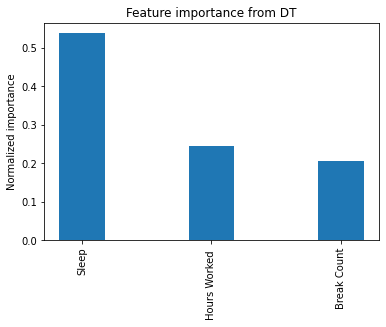

In [23]:
df_imp = getFeatureImportances(3)
df_imp

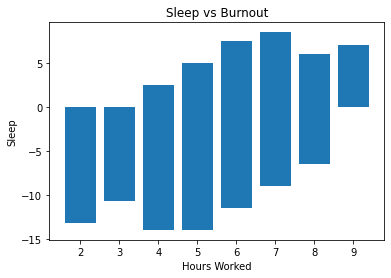

In [36]:
plt.bar(df['Sleep'], df[label])
plt.title('Sleep vs Burnout')

plt.xlabel('Hours Worked')

plt.ylabel('Sleep')
plt.show()

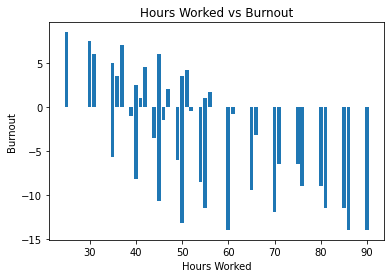

In [37]:
plt.bar(df['Hours Worked '], df[label])
plt.title('Hours Worked vs Burnout')

plt.xlabel('Hours Worked')

plt.ylabel('Burnout')
plt.show()

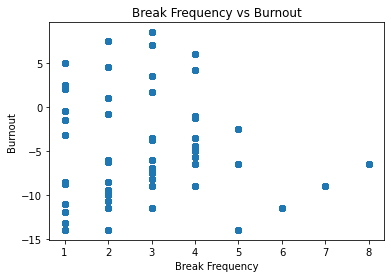

In [39]:
plt.scatter(df['Break Count'], df[label])
plt.title('Break Frequency vs Burnout')

plt.xlabel('Break Frequency')

plt.ylabel('Burnout')
plt.show()